# HHL implementation (QC final project)

20195048 Hyunseong Kim

## Problem 1

Solve the following linear system with HHL algorithm

$$\begin{bmatrix}1 & -1/3 \\ -1/3 & 1\end{bmatrix} \mathbf{x} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

## Problem 2 

Extend the problem 1 result and solve following equation

$$\frac{1}{4}
\begin{bmatrix}
15 & 9 & 5 & -3 \\
9 & 15 & 3 & -5 \\
5 & 3 & 15 & -9 \\
-3 & -5 & -9 & 15\end{bmatrix} \mathbf{x} = 
\frac{1}{2} 
\begin{bmatrix}
1\\
1\\
1\\
1
\end{bmatrix}$$

# Answer

Since the matrix already a Hermit matrix, the calculation does not require a conversion. Before we implement HHL. Let us see the exact solutions of the each system.

## Exact solutions

In [9]:
from IPython.display import display, Math

In [10]:
import sympy as sp
import numpy as np
from sympy.printing.mathml import mathml

In [11]:
scale1 = 3
A1 = sp.Matrix([[3, -1], [-1, 3]])/scale1
b1 = sp.Matrix([[0], [1]])
scale2 = 4
A2 = sp.Matrix(
    [
        [15, 9, 5, -3], 
        [9, 15, 3, -5],
        [5, 3, 15, -9],
        [-3, -5, -9, 15]])/scale2
b2 = sp.Matrix(4*[[2]])/scale2

A1_np = np.array(A1).astype(complex)
A2_np = np.array(A2).astype(complex)

In [12]:
# matrix , determinant and exact solutions
display(Math(sp.latex(A1)))
display(Math(f"$det(A_1): {A1.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A1.solve(b1).T)))
display(Math(sp.latex(A2)))
display(Math(f"$det(A_2): {A2.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A2.solve(b2).T)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In the HHL the solution vector would be encoded as an amplitude of the state vector.
That means the measurement result would show square ratio of the solution vectors. 

In problem 1; $\mathbf{x} = [1, 3]\frac{3}{8}$, the solution from the HHL would be $[1, 9]$.
In problem 2; $\mathbf{x} = [-1, 7, 11, 13]\frac{1}{32}$, the solution would be $[1, 49, 121, 169]$. 
Now, the problem 1 configuration is well shown in the reference. The below is a material to get a problem 2 configuration.

In [13]:
# A2 eigenvalues and vectors
display(A2.eigenvals())
display(Math(sp.latex(A2.eigenvects())))

{8: 1, 4: 1, 2: 1, 1: 1}

<IPython.core.display.Math object>

In [14]:
evlist = (e1, e2, e3 ,e4) = [np.array(c[0]).astype(complex) for (a, b, c) in A2.eigenvects()]
eval2 = list(A2.eigenvals().keys())
(eval2).reverse()
print("Eigenvalues of A2: ", eval2)

Eigenvalues of A2:  [1, 2, 4, 8]


## System configuration

Eigenvalues and eigenvectos of each systems

* $\{\lambda _i\}_{A_1} = \{ \frac{2}{3}, \frac{4}{3}\}$
* $\{\lambda _i\}_{A_2} = \{ 1, 2, 4, 8\}$

First system requires 2 qubits for representing the eigenvalues 01, 10, and the second system
requires 4 qubit registers, as 0001, 0010, 0100, 1000. Therefore, $N_1 =2^2, N_2 = 2^4$.  
Consequently, the desired scaled eigenvalues and the scale factors are 

$$\tilde{\lambda} = N \frac{\lambda }{2 \pi} t$$

* $\{\tilde{\lambda}_i\}_{A_1} = \{ 1, 2\}$
* $\{\tilde{\lambda}_i\}_{A_2} = \{ 1, 2, 4, 8\}$
* $t_1 = \frac{3}{4} \pi$
* $t_2 = \frac{1}{8} \pi$

Lastly, RY rotation angle is 

$$\theta_i = 2 \arcsin(\frac{1}{2^i}) \text{for } i \in [0, n_{clock})$$

therefore,

* $[\pi, \pi/3]$
* $[\pi, \pi/3, 2\arcsin(2^{-2}), 2 \arcsin(2^{-3})]$

In [15]:
t1 = 3/4 * np.pi
t2 = 1/8 * np.pi

## Implementation of HHL algorithm

Major steps of HHL algorithm

3 registers required: ancilla, main-register, b-register.

1. State preparation: Encoding $|b\rangle$ vector to the register, amplitude encoding(b).
2. Quantum Phase estimation(main, b).
3. Ancilla bit rotation(main, ancilla).
4. Inverse Quantum Phase estimation(main, b).
5. Measurement.

### Decomposition of Pauli matrix 

In the HHL algorithm there is a evolution circuit $U = \exp(i H t)$ gate of the given $A$ matrix.
Unfortunately, to implement on the gate circuit, we have to encode the given Hamiltonian as summation of 
unitary and hermit matrices. That means we needs a Pauli-polynomial of the given matrix.

Since, we can construct general unitary gate in qiskit.
However, if we want to make user-defined evolution circuit,
it would be useful.

In [16]:
import numpy as np
from itertools import combinations, combinations_with_replacement as re_combi, product
from functools import reduce

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = complex(0, 1)*np.array([[0, -1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

In [17]:
def krons(oper_list): # Operator Kronecker delta
    return reduce(np.kron, oper_list)
def get_pauli_xz_family_n_qubit(n, fam="Z"): # Get X-Z families of Pauli-groups
    G = Z if fam=="Z" else X
    return list(map(krons, product([I, G], repeat=int(n)))), list(map(lambda x: "".join(x), product(f"I{fam}", repeat=int(n))))
def get_pauli_familiy(n): # Get total Pauli elements of the given n number of qubit system.
    p_xs, p_xs_str = get_pauli_xz_family_n_qubit(n, fam="X")
    p_zs, p_zs_str = get_pauli_xz_family_n_qubit(n, fam="Z")

    p_g = []
    p_g_str =[]
    for x_i, x_str in zip(p_xs, p_xs_str):
        for z_j, z_str in zip(p_zs, p_zs_str):
            g = x_i@z_j
    
            g_coef, g_str = get_coef(x_str, z_str)
    
            p_g.append(g_coef*g)
            p_g_str.append(g_str)
    return p_g, p_g_str    

def get_coef(x_str, z_str): # i coefficient in construction of general pauli-element from XZ elements.
    n = len(x_str)
    x_str = x_str.replace("X", "1")
    x_str = x_str.replace("I", "0")
    z_str = z_str.replace("Z", "1")
    z_str = z_str.replace("I", "0")
    
    x_int = int(x_str, 2)
    z_int = int(z_str, 2)
    
    y_pos = format(x_int&z_int, f"0{n}b")
    z_pos = format((x_int|z_int) - x_int, f"0{n}b")
    x_pos = format((x_int|z_int) - z_int, f"0{n}b")

    g_str = []
    for x,y,z in zip(x_pos, y_pos, z_pos):
        if x==y and y==z:
            g_str.append("I")
        elif x== "1":
            g_str.append("X")
        elif y == "1":
            g_str.append("Y")
        else:
            g_str.append("Z")
    return 1j**y_pos.count("1"), "".join(g_str)
    
def frobenius_inner(A, B): # Frobenius inner product.
    n, n2 = A.shape
    return np.trace((A.conj().T)@B)/(n)

def get_pauli_coefficient(A): # Get Pauli coefficients of the given Hermit matrix A.
    k, k2 = A.shape
    n = int(np.log2(k))
    p_fam, p_str = get_pauli_familiy(n)
    
    coef = {}
    for p_m, p_m_str in zip(p_fam, p_str):
        coef[p_m_str] = frobenius_inner(p_m, A)
    return coef

In [18]:
coef_A1 = get_pauli_coefficient(A1_np)
coef_A2 = get_pauli_coefficient(A2_np)

In [19]:
coef_A1

{'I': (1+0j), 'Z': 0j, 'X': (-0.3333333333333333+0j), 'Y': 0j}

In [20]:
coef_A2

{'II': (3.75+0j),
 'IZ': 0j,
 'ZI': 0j,
 'ZZ': 0j,
 'IX': 0j,
 'IY': 0j,
 'ZX': (2.25+0j),
 'ZY': 0j,
 'XI': 0j,
 'XZ': (1.25+0j),
 'YI': 0j,
 'YZ': 0j,
 'XX': 0j,
 'XY': 0j,
 'YX': 0j,
 'YY': (0.75+0j)}

The $A_1$ and $A_2$ become

$$A_1 = I - \frac{1}{3}X$$
$$A_2 = 3.75 II + 1.25 XZ + 2.25 ZX + 0.75 YY$$

About the commuting relationship, $A_1$ components are tirvially commuting each other.
For $A_2$ elements, we can use a method suggested by Reggio et al (2023).

`Ben Reggio, Nouman Butt, Andrew Lytle, and Patrick Draper. Fast Partitioning of Pauli
Strings into Commuting Families for Optimal Expectation Value Measurements of Dense
Operators, June 2023. arXiv:2305.11847 [hep-lat, physics:hep-ph, physics:quant-ph].`

**Theorem**
> For two pauli strings, there are X, Z family decomposition such as $P_1 = x_1 * z_1$ and $P_2 = x_2 * z_2$. 
The given Pauli strings are commuting if and only if $[x_1, z_2]$ and $[x_2, z_1]$ are either commute or anti-commute.



Now see below,

<center>

|Element|X-family|Z_family|
|:---:|:---:|:---:|
|XZ|XI|IZ|
|ZX|IX|ZI|
|YY|XX|ZZ|

</center>

All of them are anticommute, in cross line elements of X, Z family columns.
Therefore, we don't have to worry about the anticommute relationship on implementation.

In [21]:
# Build evolution unitary matrices.
# U1
I =sp.eye(2)
X = sp.Matrix([[0,1] ,[1,0] ])
ai = 1*t1
ax = sp.Number(1/3)*t1
U1 = np.array(sp.exp(1j * ai * I) @ sp.exp(1j * ax * X)).astype(complex) # You can use trotterization circuit but it becomes too complicated.
U1_inv = np.linalg.inv(U1)
U1

array([[-0.5+0.5j, -0.5-0.5j],
       [-0.5-0.5j, -0.5+0.5j]])

In [93]:
# U2 construction from Pauli polynomial
II = sp.kronecker_product(sp.eye(2), sp.eye(2))
XZ = sp.kronecker_product(sp.Matrix(X), sp.Matrix(Z))
ZX = sp.kronecker_product(sp.Matrix(Z), sp.Matrix(X))
YY = sp.kronecker_product(sp.Matrix(Y), sp.Matrix(Y))
aii = 3.75*t2
axz = 1.25*t2
azx = 2.25*t2
ayy = 0.75*t2
U2 = np.array(sp.exp(1j * aii * II) @ sp.exp(1j * azx * ZX) @ sp.exp(1j * axz * XZ) @sp.exp(1j * ayy * YY)).astype(complex)
U2_inv = np.linalg.inv(U2)
U2

array([[ 0.15774658+0.52244755j, -0.65774658-0.02244755j,
        -0.30419319-0.16889416j,  0.19580681+0.33110584j],
       [-0.65774658-0.02244755j,  0.15774658+0.52244755j,
        -0.19580681-0.33110584j,  0.30419319+0.16889416j],
       [-0.30419319-0.16889416j, -0.19580681-0.33110584j,
         0.15774658+0.52244755j,  0.65774658+0.02244755j],
       [ 0.19580681+0.33110584j,  0.30419319+0.16889416j,
         0.65774658+0.02244755j,  0.15774658+0.52244755j]])

In [94]:
sp.exp(1j * aii * II)

Matrix([
[1.0*exp(1.47262155637022*I),                           0,                           0,                           0],
[                          0, 1.0*exp(1.47262155637022*I),                           0,                           0],
[                          0,                           0, 1.0*exp(1.47262155637022*I),                           0],
[                          0,                           0,                           0, 1.0*exp(1.47262155637022*I)]])

For convinence, the below code used `UnitaryGate` routine from Qiskit extension. It is a grammar sugar of qiskit. Since, we get a decomposed representation of the $A$ matrices of each problems, let us find a corresponding `CNOT` and single gate combination.

$$U = \exp(i \hat{n}\cdot \sigma \theta) = \cos(\theta) \hat{I} + i \sin(\theta) \hat{n}\cdot (\sigma)$$

The X, Y, Z pauli gates are well known, however, what about the II rotation? Is it worth to mark it?
The answer is YES. In the n-qubit Hamiltonian, $\text{I}^{\otimes n}$ affects nothing to the whole system. It just yields a global phase difference.
However, with `CNOT` and the other controll gates in n+1 system, it becomes local relative phase difference of the system. 
For example, think about Aharonov Bohm effect in splitted two beams are combined at the end of the optical path.
The difference only arise to a phase of one of the beam, however, the phase effect is well observed in final measurement.

Mathematically, the answer is how we can find a unitary matrix combination of the next large matrix being combined with tensor product.

$$\text{C-}\exp(i a \hat{\text{II}} \theta) = \begin{pmatrix}1 & 0 & 0 & 0       & 0 & 0 & 0 & 0\\  0 & 1 & 0 & 0       & 0 & 0 & 0 & 0\\  0 & 0 & 1 & 0       & 0 & 0 & 0 & 0\\  0 & 0 & 0 & 1       & 0 & 0 & 0 & 0\\  0 & 0 & 0 & 0       & \exp(i a\theta) & 0 & 0 & 0\\  0 & 0 & 0 & 0       & 0 & \exp(i a\theta) & 0 & 0\\  0 & 0 & 0 & 0       & 0 & 0 & \exp(i a\theta) & 0\\  0 & 0 & 0 & 0       & 0 & 0 & 0 & \exp(i a\theta)\\  \end{pmatrix}$$

Looks complicated, but the answer is simple. 

$$P(a\theta) \otimes I \otimes I$$

The overall C-U gate in Problem 2 decomposition is illustrated on the below figure.

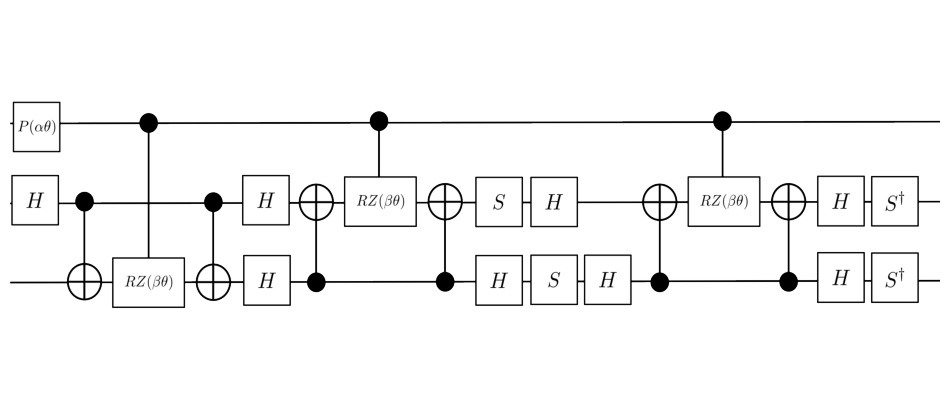

In [95]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(12,6))
img = mpimg.imread('U2.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

The $a\alpha \theta$ is $a_{ii} t_2$ and  $\beta \theta$ value of the figures are $2 a_{xz}t_2, 2a_{zx}t_2 , 2 a_{yy} t_2$, repectively.

In [96]:
CNOT = sp.kronecker_product(sp.Matrix([[1, 0],[0, 0]]), I)  + sp.kronecker_product(sp.Matrix([[0, 0],[0, 1]]),X)
CNOT_u = sp.kronecker_product(I, sp.Matrix([[1, 0],[0, 0]]))  + sp.kronecker_product(X, sp.Matrix([[0, 0],[0, 1]]))
H = sp.Matrix([[1, 1],[1, -1]])/sp.sqrt(2)
S = sp.Matrix([[1, 0], [0, 1j]])
Sdg = sp.Matrix([[1, 0], [0, -1j]])
RZ = lambda a: sp.exp(-1j*a*sp.Matrix([[1, 0],[0, -1]])/2)

def get_uintary(circuit):
    U = sp.eye(4)
    for g in circuit:
        U = g@U
    return U


In [126]:
custom_circuit = [
    sp.kronecker_product(H, I), # XZ
    CNOT,
    sp.kronecker_product(I, RZ(2*axz)),
    CNOT,
    sp.kronecker_product(H, H), # XZ end ZX start
    CNOT_u,
    sp.kronecker_product(RZ(2*azx), I),
    CNOT_u,
    sp.kronecker_product(I, H), # ZX end
    sp.kronecker_product(S, S), # YY state
    sp.kronecker_product(H, H),
    CNOT_u,
    sp.kronecker_product(RZ(2*ayy), I),
    CNOT_u,
    sp.kronecker_product(H, H),
    sp.kronecker_product(Sdg, Sdg), # YY end
]
U2_custom = np.exp(1j*aii)*np.array(get_uintary(custom_circuit)).astype(complex).conj()

In [128]:
from qiskit.visualization import plot_state_hinton

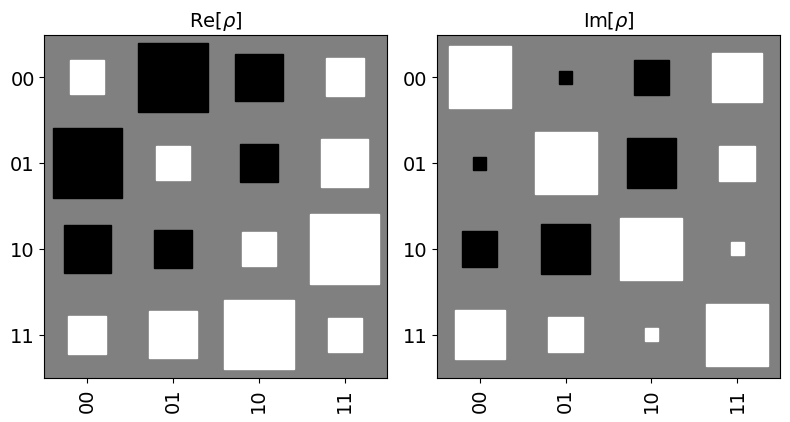

In [129]:
plot_state_hinton(U2)

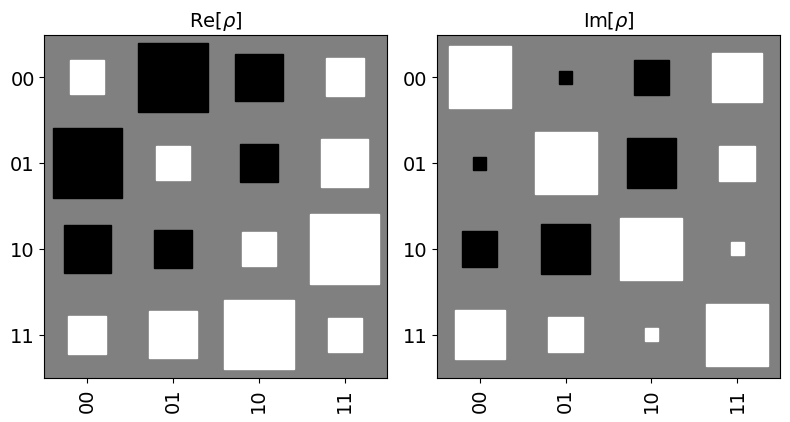

In [130]:
plot_state_hinton(U2_custom)

---

In [214]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import partial_trace, Operator
from qiskit.visualization import plot_histogram
#from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate

## Problem 1 - implementation

In [215]:
from qiskit.extensions import UnitaryGate, CSGate

In [216]:
y_theta1 = [np.pi, np.pi/3]
U1_1 = U1
U1_2 = U1@U1
U1_1_inv = U1_inv
U1_2_inv = U1_inv@U1_inv

In [217]:
cu11     = UnitaryGate(U1_1, label="U11").control()
cu12     = UnitaryGate(U1_2, label="U12").control()
cu11_inv = UnitaryGate(U1_1_inv, label="U11_inv").control()
cu12_inv = UnitaryGate(U1_2_inv, label="U12_inv").control()

In [218]:
num_ancilla_register = 1
num_clock_register = 2
num_vector_register = 1

In [219]:
qr_ancilla = QuantumRegister(num_ancilla_register, name="ancilla")
qr_clock = QuantumRegister(num_clock_register, name="clock")
qr_vector = QuantumRegister(num_vector_register, name="vector")
cr = ClassicalRegister(2, name = "classic")

In [220]:
qc = QuantumCircuit(qr_ancilla, qr_clock, qr_vector, cr, name="HHL")

In [221]:
qc.x(qr_vector)
qc.barrier() # QPE initiate
qc.h(qr_clock[:])

qc.append(cu11, [qr_clock[0],  qr_vector[0]])
qc.append(cu12, [qr_clock[1],  qr_vector[0]])

qc.append(QFT(2).inverse(), qr_clock[:])

for i, angle in zip(range(0, len(qr_clock)), y_theta1):
    qc.cry(angle, qr_clock[i], qr_ancilla)

qc.measure(qr_ancilla, cr[0])

qc.append(QFT(2), qr_clock[:])

qc.append(cu12_inv, [qr_clock[1],  qr_vector[0]])
qc.append(cu11_inv, [qr_clock[0],  qr_vector[0]])

qc.h(qr_clock[:])
qc.barrier()

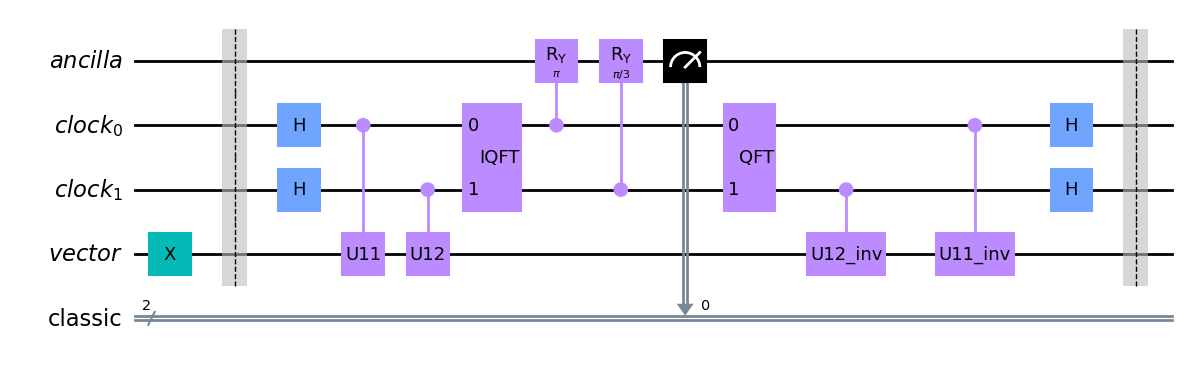

In [222]:
qc.draw("mpl")

### Result 1

In [223]:
# Statevector
state_vector_sim = Aer.get_backend('statevector_simulator')
result_state1 = execute(qc, state_vector_sim).result()
state_vec_1 = result_state1.get_statevector()
state_vec_1.data

array([ 0.00000000e+00+0.00000000e+00j, -3.16227766e-01+1.75342943e-16j,
        0.00000000e+00+0.00000000e+00j, -2.21544366e-16-9.43362978e-16j,
        0.00000000e+00-0.00000000e+00j,  2.12788087e-16+1.93095841e-15j,
       -0.00000000e+00+0.00000000e+00j, -9.93013661e-16+1.89765027e-18j,
        0.00000000e+00+0.00000000e+00j,  9.48683298e-01-9.26418484e-16j,
        0.00000000e+00+0.00000000e+00j,  5.12221653e-16-5.70982855e-16j,
       -0.00000000e+00+0.00000000e+00j,  7.85138492e-17+4.77473352e-15j,
       -0.00000000e+00+0.00000000e+00j,  4.71681489e-16+8.69923763e-17j])

In [224]:
x0 = state_vec_1.data[1] # 01
x1 = state_vec_1.data[9] # 11
x0_n = x0.conj()*x0
x1_n = x1.conj()*x1

x0_n, x1_n

((0.10000000000000007-6.215590493757663e-34j),
 (0.8999999999999999-9.635332771471626e-33j))

In [225]:
x1_n/x0_n

(8.999999999999993-4.0413013270897305e-32j)

Which was predicted at first $\mathbf{x} = [\frac{3}{8}, \frac{9}{8}]^T$

In [226]:
# Measurement
qc.measure(qr_ancilla, cr[0])
qc.measure(qr_vector , cr[1])

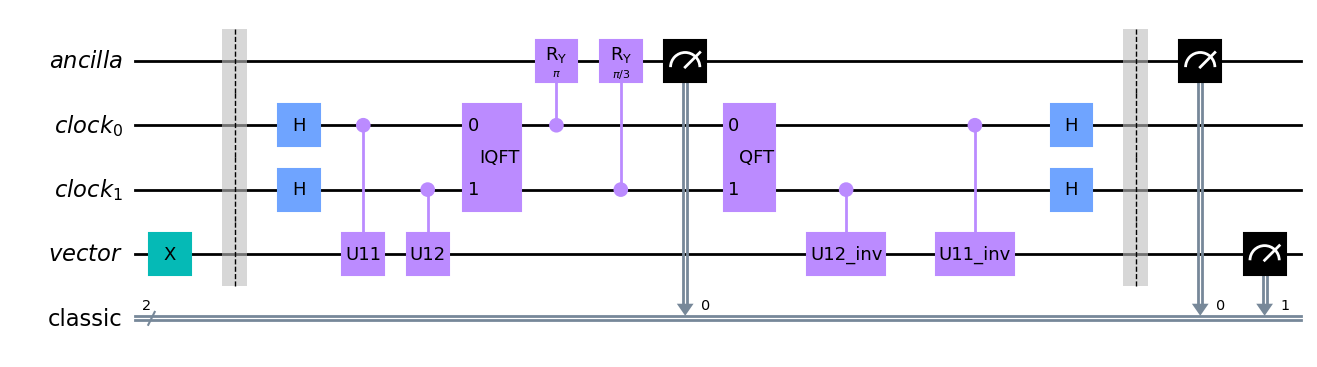

In [227]:
qc.draw("mpl")

In [228]:
shots =10000
simulator = Aer.get_backend('qasm_simulator')


In [229]:
result = execute(qc, simulator, shots=shots).result()
counts = result.get_counts(qc)

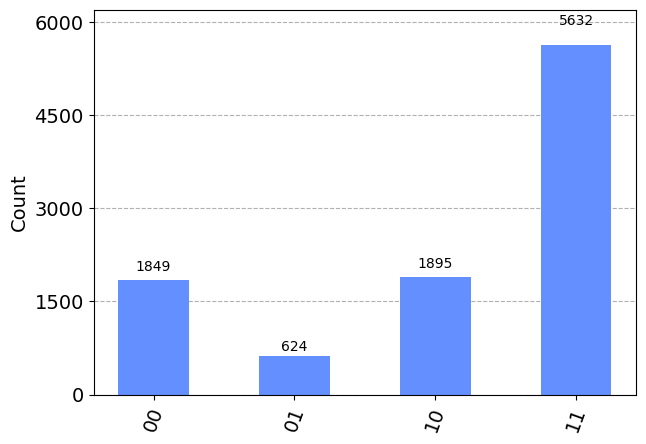

In [230]:
plot_histogram(counts)

In [231]:
counts

{'01': 624, '00': 1849, '10': 1895, '11': 5632}

In [232]:
x0_result = np.array((counts["01"]/ shots,counts["11"]/shots))
x0_result /= x0_result[0]

print("HHL result: ", np.sqrt(x0_result)*3/8)
display(Math("$\mathbf{x}: " + sp.latex(A1.solve(b1).T)))

HHL result:  [0.375      1.12660142]


<IPython.core.display.Math object>

$\square$

## Problem 2 - Implementation

In [233]:
from qiskit.circuit.library import CPhaseGate

In [234]:
y_theta2 = [2*np.arcsin(1/(2**i)) for i in range(0,4)]
U2_1 = U2
U2_2 = U2@U2
U2_3 = U2_2@U2_2
U2_4 = U2_3@U2_3
U2_1_inv = U2_inv
U2_2_inv = U2_1_inv@U2_1_inv
U2_3_inv = U2_2_inv@U2_2_inv
U2_4_inv = U2_3_inv@U2_3_inv

In [235]:
cu21     = UnitaryGate(U2_1, label="U21").control()
cu22     = UnitaryGate(U2_2, label="U22").control()
cu23     = UnitaryGate(U2_3, label="U23").control()
cu24     = UnitaryGate(U2_4, label="U24").control()
cu21_inv = UnitaryGate(U2_1_inv, label="U21_inv").control()
cu22_inv = UnitaryGate(U2_2_inv, label="U22_inv").control() 
cu23_inv = UnitaryGate(U2_3_inv, label="U23_inv").control()
cu24_inv = UnitaryGate(U2_4_inv, label="U24_inv").control()

In [236]:
# System Configuration
num_ancilla_register = 1
num_clock_register = 4
num_vector_register = 2

In [237]:
# Quantum circuit register defintion
qr_ancilla2 = QuantumRegister(num_ancilla_register, name="ancilla")
qr_clock2 = QuantumRegister(num_clock_register, name="clock")
qr_vector2 = QuantumRegister(num_vector_register, name="vector")
cr2 = ClassicalRegister(3, name = "classic")

In [238]:
qc2 = QuantumCircuit(qr_ancilla2, qr_clock2, qr_vector2, cr2, name="HHL_2")

In [239]:
# Circuit configuration
qc2.h(qr_vector2) # Initiate b vector

qc2.barrier() # QPE initiate
qc2.h(qr_clock2)

qc2.append(cu21, [qr_clock2[0],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu22, [qr_clock2[1],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu23, [qr_clock2[2],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu24, [qr_clock2[3],  qr_vector2[0], qr_vector2[1]])

qc2.append(QFT(4).inverse(), qr_clock2[:])

qc2.barrier()
for i, angle in zip(range(0, len(qr_clock2)), y_theta2):
    qc2.cry(angle, qr_clock2[i], qr_ancilla2)

qc2.measure(qr_ancilla2, cr2[0])
qc2.barrier()
# QFT
qc2.append(QFT(4), qr_clock2[:])
#
qc2.append(cu24_inv, [qr_clock2[3],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu23_inv, [qr_clock2[2],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu22_inv, [qr_clock2[1],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu21_inv, [qr_clock2[0],  qr_vector2[0], qr_vector2[1]])
qc2.barrier()
qc2.h(qr_clock2[:])
qc2.barrier()

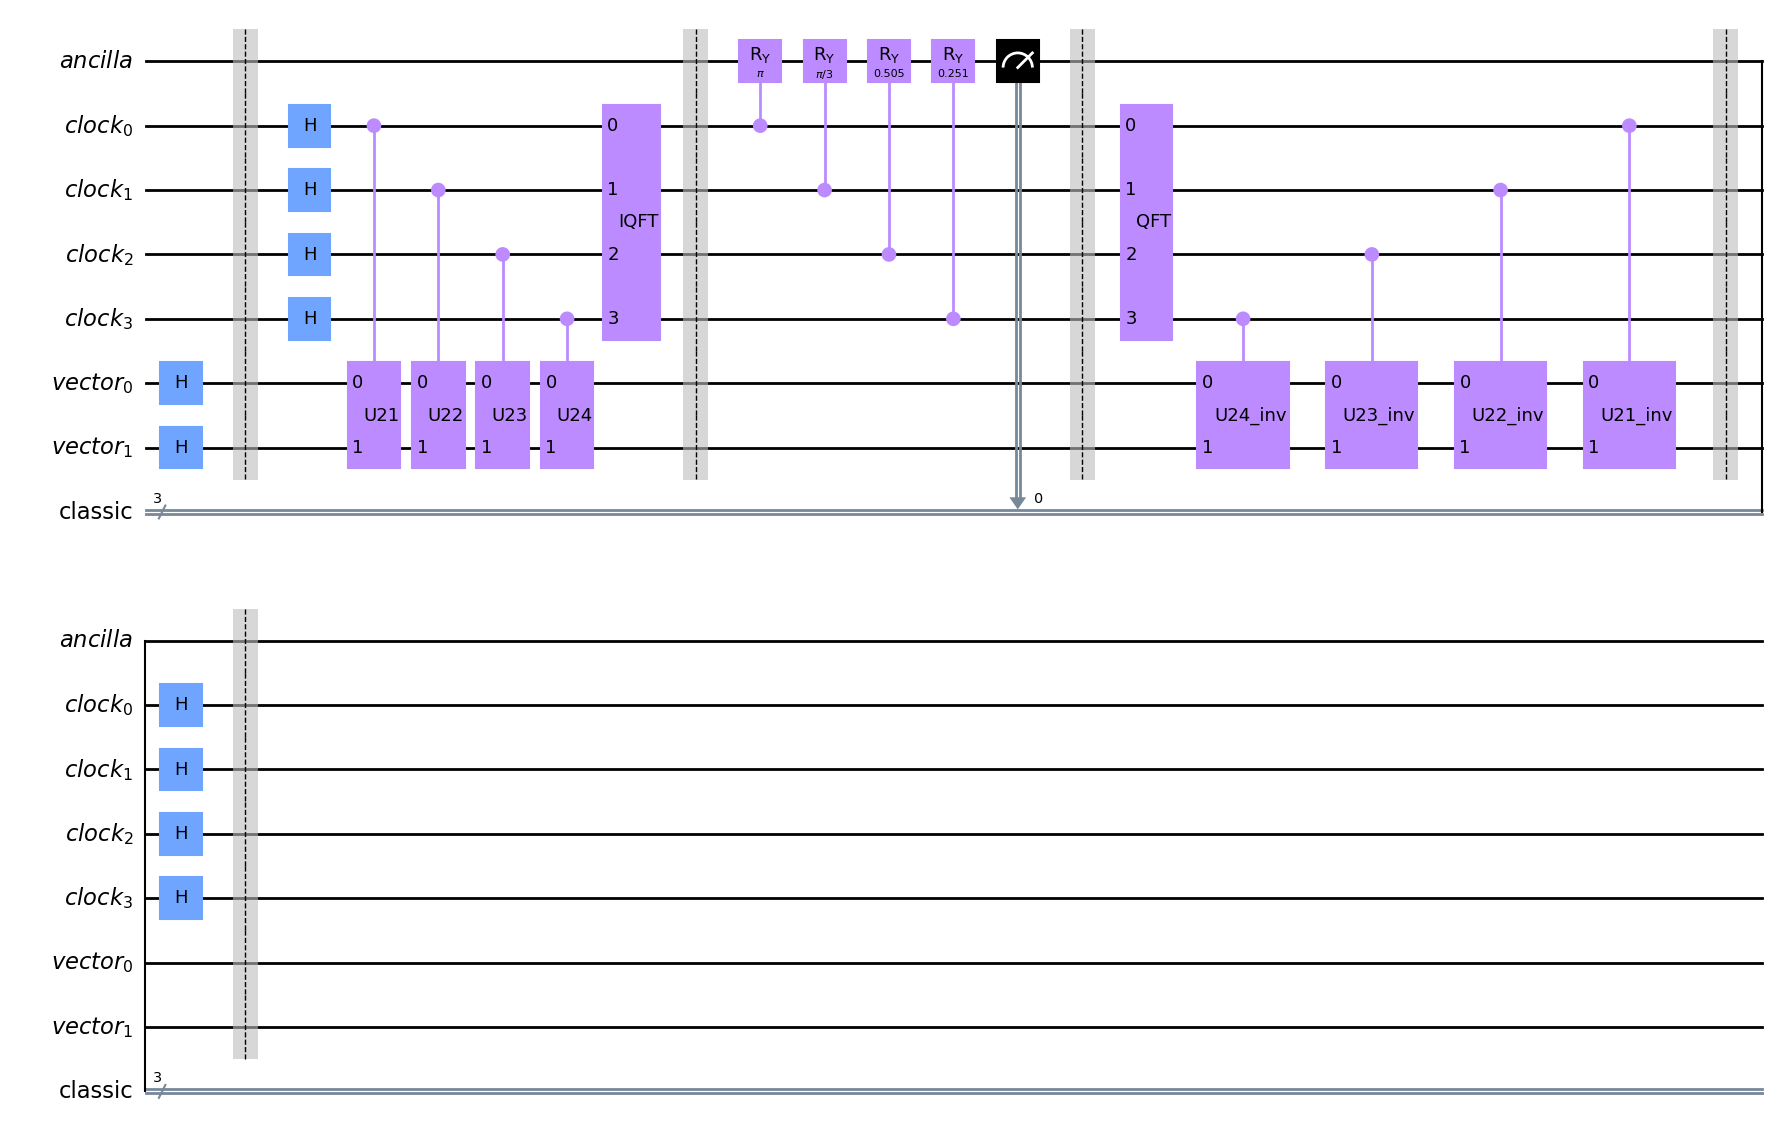

In [240]:
qc2.draw("mpl")

In [241]:
state_vector_sim = Aer.get_backend('statevector_simulator')
simulator = Aer.get_backend('qasm_simulator')


In [242]:
while True:
    result = execute(qc2, state_vector_sim, shots=1).result()
    counts = result.get_counts(qc2)
    if '001' in counts:
        break


In [243]:
state_vec_2 = result.get_statevector(decimals=3)

In [244]:
values = state_vec_2.data

In [245]:
state_vec_2

Statevector([ 0.   +0.j, -0.054+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j, -0.   -0.j,
              0.   +0.j, -0.   -0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j, -0.   +0.j,
              0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.   +0.j, -0.   +0.j,  0.   +0.j,  0.38 -0.j,  0.   +0.j,
             -0.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j, -0.   +0.j,
              0.   +0.j,  0.   -0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
             -0.   -0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,  0.   +0.j,
              0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
             -0.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j, -0.   -0.j,
              0.   +0.j, -0.   -0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.597-0.j,  0.   +0.j,  0.   +0.j,  0

In [246]:
# Get Probability of the states
state_amplitude = state_vec_2.data.conj()*state_vec_2.data
measure = state_amplitude/state_amplitude[1]
print("Measure probability from state vector")
measure[measure>0]

Measure probability from state vector


array([  1.        +0.j,  49.51989026+0.j, 122.22530864+0.j,
       170.44753086+0.j])

In [247]:
# Get solution
result_values = np.array([values[1], values[33], values[65], values[97]])
result_vector = -result_values/result_values.min()
print("Solution from state vector")
result_vector

Solution from state vector


array([-1.        -0.j,  7.03703704-0.j, 11.05555556-0.j, 13.05555556-0.j])

In [248]:
qc2.measure(qr_ancilla2, cr2[0])
qc2.measure(qr_vector2[0], cr2[1])
qc2.measure(qr_vector2[1], cr2[2])

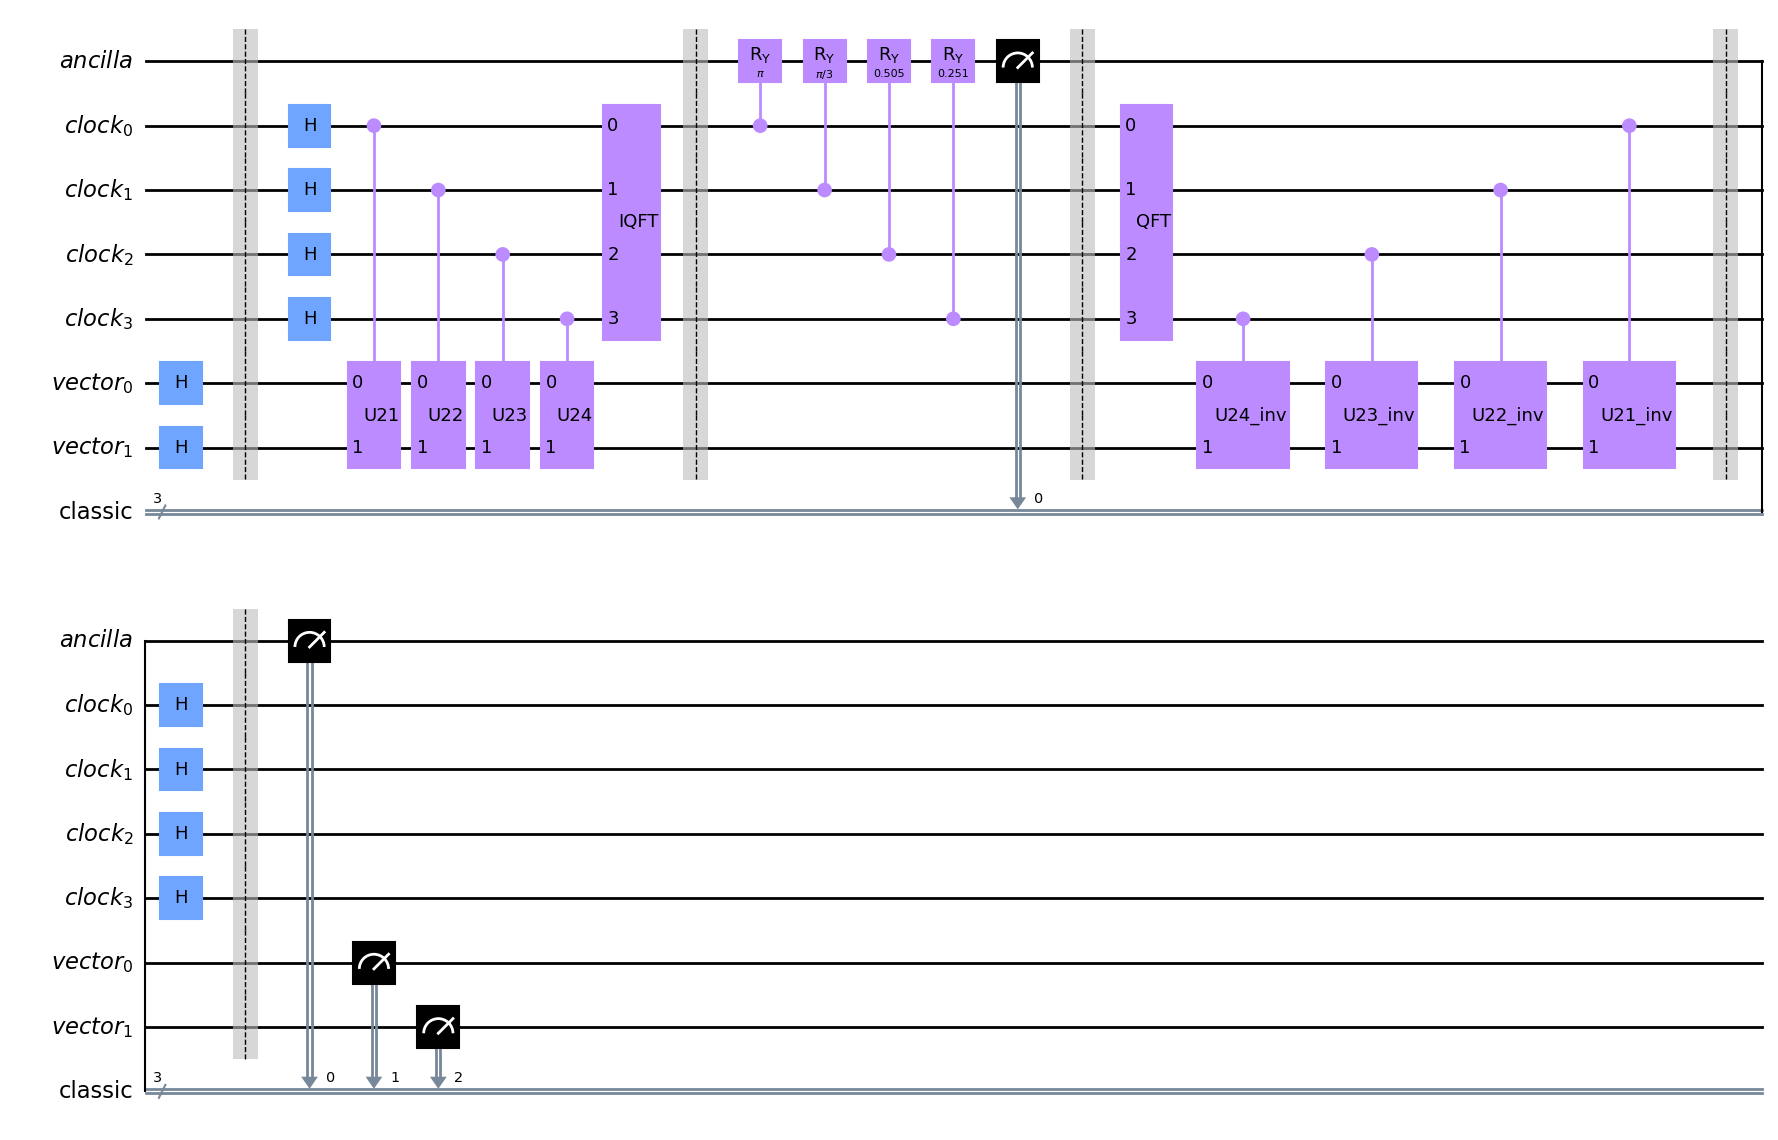

In [249]:
qc2.draw("mpl")

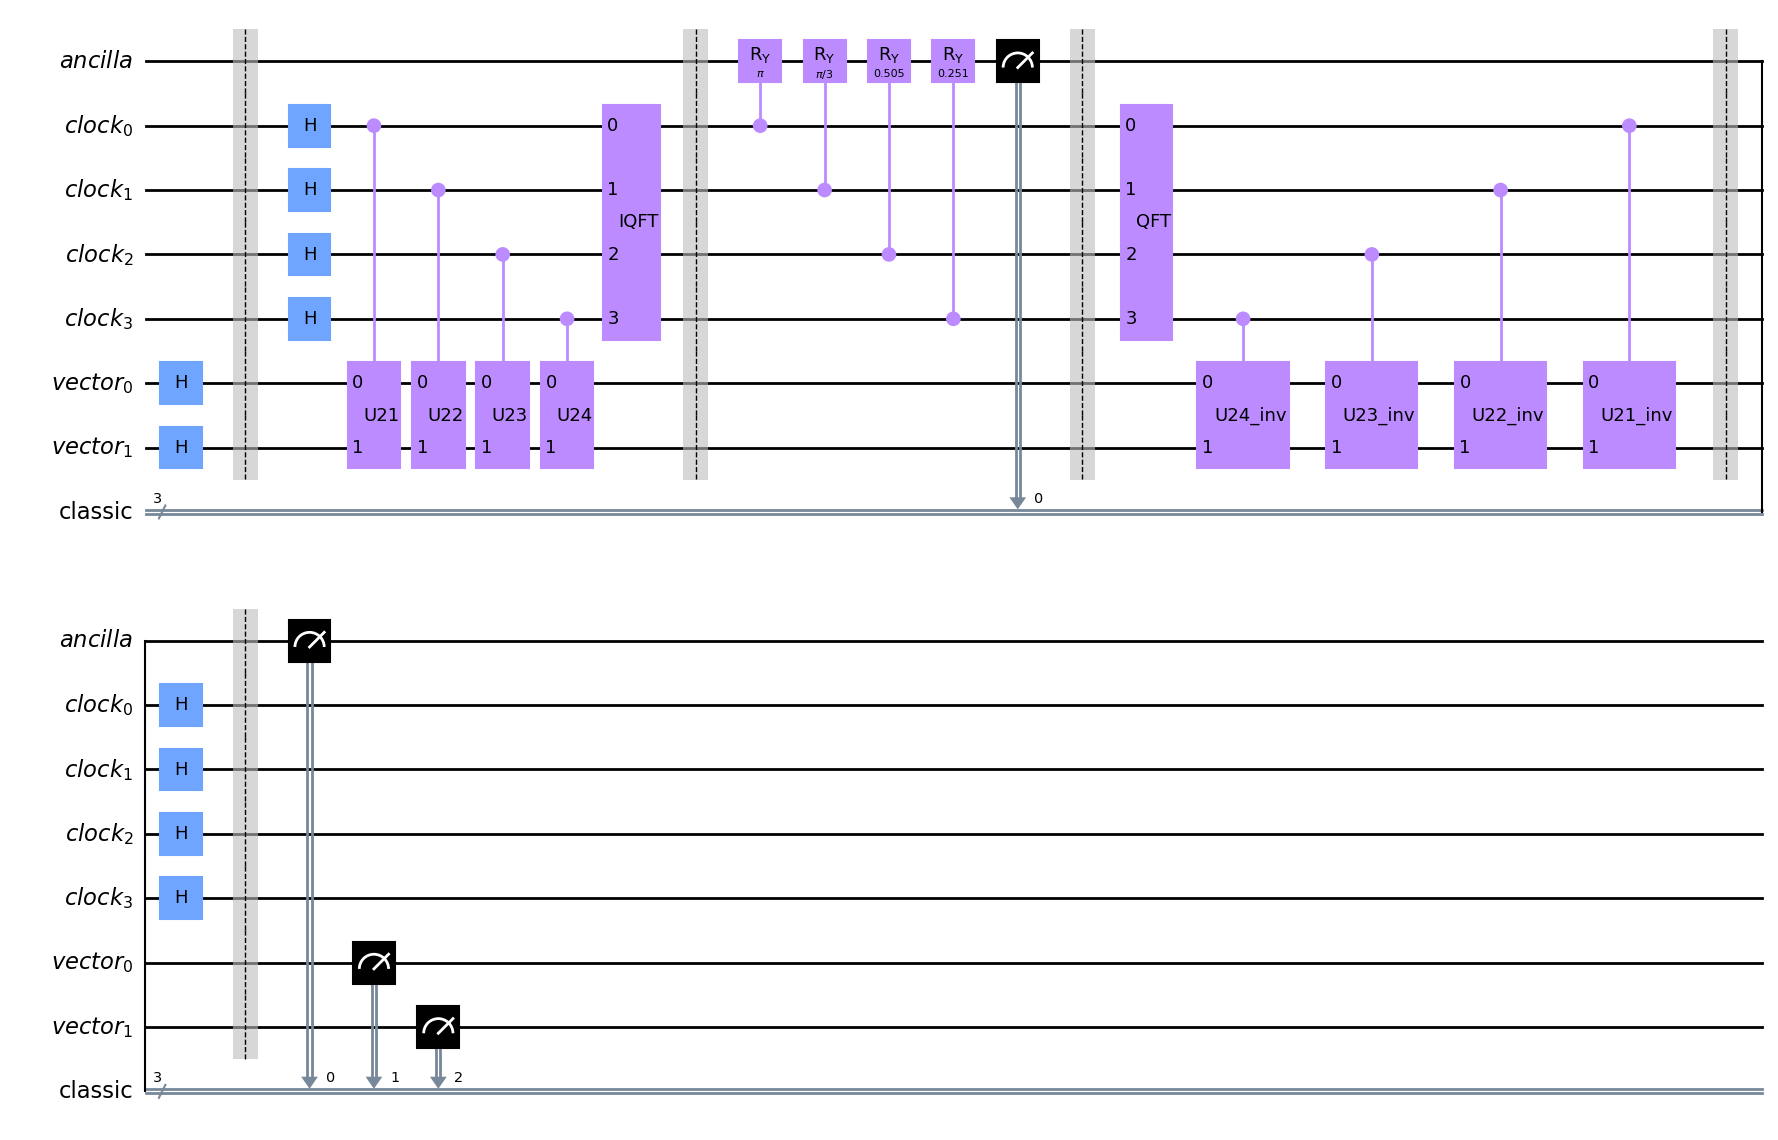

In [250]:
qc2.draw("mpl")

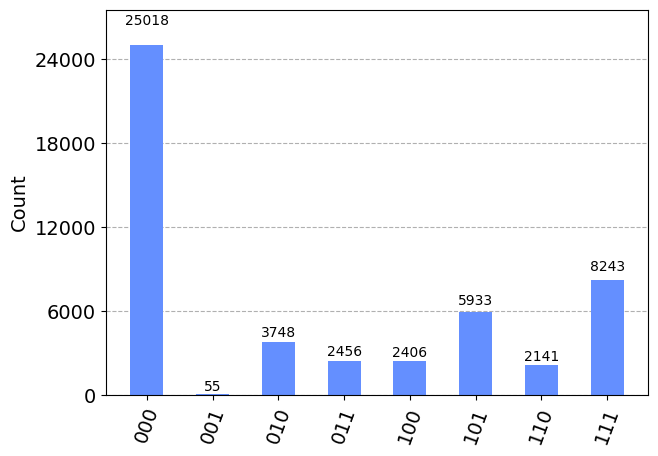

In [251]:
result = execute(qc2, state_vector_sim, shots=50000).result()
counts = result.get_counts(qc2)
plot_histogram(counts)

The proper values are 001, 011, 101, 111. 

In [252]:
keys = ["001", "011", "101", "111"]
values = np.array([counts[key] for key in keys])

In [253]:
display(np.sqrt(values/values.min())/32)

array([0.03125   , 0.20882518, 0.32456811, 0.38257037])

In [254]:
np.array([-1, 7, 11, 13])/32

array([-0.03125,  0.21875,  0.34375,  0.40625])

The above result from HHL measurement only show the amplitude of the solution vector, the true value is $[-1, 7, 11, 13]/32$, the sign of the each position elements requires additional process. $\square$